In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.path as mpath
from matplotlib.colors import LinearSegmentedColormap
%matplotlib inline
from starkhelium import *
from tqdm import trange, tqdm
import os

au_to_ghz = 10**-9 * E_h /h
au_to_cm = E_h / (100 * h * c)

# Stark map - Parallel fields

### Calculate Stark interaction matrix, $H_S$ for each $m_{\ell}$ manifold individually (for energy levels)

In [6]:
# Calculate everything needed to plot the Stark map. Use Eigenvectors to compute state-mixing weights
# quantum numbers
nmin = 5
nmax = 6
S = 1
field_orientation = 'parallel'
m_vals = np.array([0,1,-1,2,-2])
n_vals, L_vals, J_vals, neff, En, H_0, mat_S = [], [], [], [], [], [], []

for m_val in m_vals:
    n_vals_tmp, L_vals_tmp = get_nl_vals(nmin, nmax, m_val)
    J_vals_tmp = get_J_vals(S, L_vals_tmp, diff=1)
    # quantum defects
    neff_tmp = n_vals_tmp - get_qd(S, n_vals_tmp, L_vals_tmp, J_vals_tmp)
    # energy levels
    En_tmp = En_0(neff_tmp)# W_n(S, n_vals_tmp, L_vals_tmp, J_vals_tmp)
    # field-free Hamiltonian
    H_0_tmp = np.diag(En_tmp)
    # find the off-diagonal terms of the Stark interaction matrix
    mat_S_tmp = stark_matrix_select_m(neff_tmp, L_vals_tmp, m_val, field_orientation, dm_allow=[0])
    
    # Save each m variable into arrays
    n_vals.append(n_vals_tmp)
    L_vals.append(L_vals_tmp)
    J_vals.append(J_vals_tmp) 
    neff.append(neff_tmp) 
    En.append(En_tmp) 
    H_0.append(H_0_tmp)
    mat_S.append(mat_S_tmp)

calculate Stark terms: 100%|██████████| 7/7 [00:00<00:00, 702.46it/s]


### Diagonalise the full Hamiltonian, for each $m_{\ell}$ manifold individually

In [11]:
# specify the electric field
field = np.linspace(3.0*10**5, 6.0*10**5, 501) # V /cm
field_au = field * 100 / (En_h_He/(e*a_0_He))
# specify the magnetic field (in Telsa)
B_z = 10.0
# (in atomic units)
B_z_au = B_z / (hbar/(e*a_0_He**2))

# diagonalise for each field
eig_vals, eig_vecs = [], []
for m_idx, m_val in enumerate(m_vals):
    # Zeeman interaction Hamiltonian
    H_Z = np.diag(E_zeeman(np.ones_like(n_vals[m_idx])*m_val, B_z_au))
    eig_vals_tmp, eig_vecs_tmp = stark_map_vec(H_0[m_idx], mat_S[m_idx], field_au, H_Z=H_Z)
    eig_vals.append(eig_vals_tmp)
    eig_vecs.append(eig_vecs_tmp)

diagonalise Hamiltonian: 100%|██████████| 501/501 [00:00<00:00, 21455.88it/s]


### Plot the Stark map

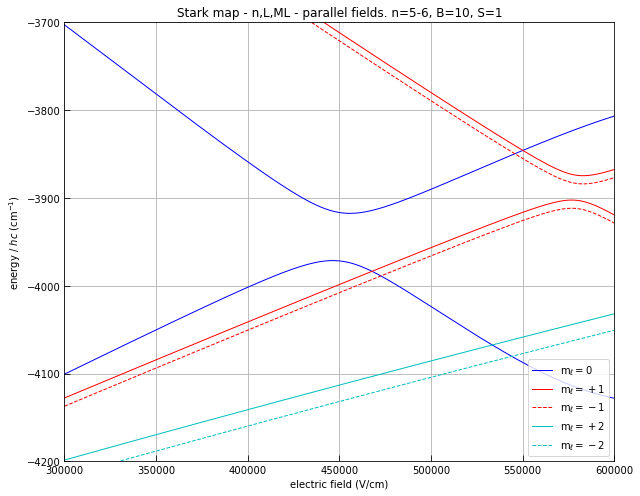

In [12]:
plt.figure(figsize=(9,7))
linestyles = ['b', 'r', '--r', 'c', '--c', 'y', '--y', 'k', '--k']
linewidths = [5, 4, 4, 3, 3, 2, 2, 1, 1]
labels = ['m$_{\ell} = 0$', 'm$_{\ell} = +1$', 'm$_{\ell} = -1$', 'm$_{\ell} = +2$', 'm$_{\ell} = -2$',
         'm$_{\ell} = +3$', 'm$_{\ell} = -3$', 'm$_{\ell} = +4$', 'm$_{\ell} = -4$']
linewidths = np.ones(len(m_vals))
for i, m_val in enumerate(m_vals):
    plt.plot(field, eig_vals[i]*au_to_cm, linestyles[i], lw=1, label=labels[i])
plt.xlabel('electric field (V/cm)')
plt.ylabel('energy / $h c$ (cm$^{-1}$)')
plt.gca().tick_params(direction='in', length=6)

from collections import OrderedDict
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='lower right')

plt.title('Stark map - n,L,ML - parallel fields. n=5-6, B=10, S=1')
plt.xlim(300000, 600000)
plt.ylim(-4200, -3700)
plt.grid()
plt.tight_layout()
#plt.savefig('Stark-Zeeman map.pdf')

In [13]:
constants_info()

,Constant,Value
0,"speed of light in vacuum, $c$",299792458
1,"Planks constant, $h$",6.62607004e-34
2,"Reduced Planks constant, $\hbar$",1.0545718001391e-34
3,"Rydberg constant, $R_{\infty}$",10973731.568508
4,"electron charge, $e$",1.6021766208e-19
5,fine structure constant,0.0072973525664
6,atomic mass,1.66053904e-27
7,Hatree energy,4.35974465e-18
8,Hatree energy (helium),4.359147121611e-18
9,"Bohr radius, $a_0$",5.2917721067e-11
